In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.express as px
import plotly.graph_objects as go


# Location Distribution on Map

In [2]:
all_batch = pd.read_csv('../combined_and_clean_data/combined_All_batch_participants.csv')

In [3]:
all_batch['Location'] = all_batch['Location'].replace('Taninthary', 'Tanintharyi')

In [4]:
myanmar_map = gpd.read_file('../geodata/myanmar_geo.geojson')
myanmar_map = myanmar_map.to_crs(epsg=3857)

In [5]:
location_count_df = all_batch['Location'].value_counts().reset_index()
location_count_df.columns = ['Location', 'Student_Count']
location_count_df

,Location,Student_Count
0,Yangon,23
1,Mandalay,7
2,Mon,5
3,Sagaing,4
4,Shan,3
5,Magway,3
6,Thailand (Mae Sot),2
7,Kachin,2
8,Kayin,2
9,Bago,1


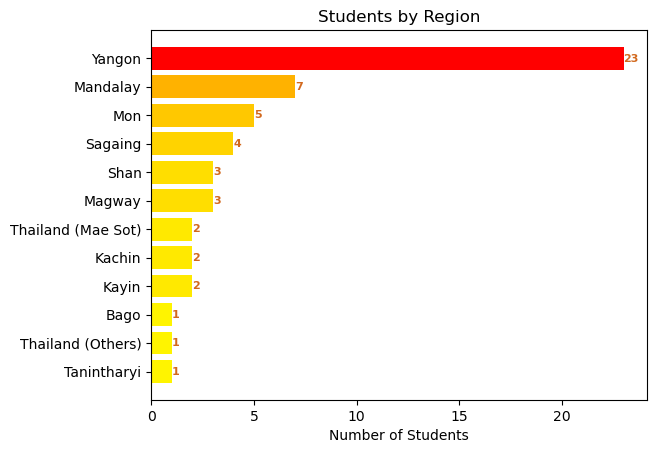

In [6]:
plt.barh(
    location_count_df['Location'], 
    location_count_df['Student_Count'], 
    height=0.8, 
    color= plt.cm.autumn_r(location_count_df['Student_Count']/location_count_df['Student_Count'].max())
    )
plt.gca().invert_yaxis()

for i, (count, location) in enumerate(zip(location_count_df['Student_Count'], location_count_df['Location'])):
    plt.text(count, i, f'{count}', va='center', ha='left', fontsize=8, color='chocolate', weight='bold')

plt.title('Students by Region')
plt.xlabel('Number of Students')
plt.show()

In [7]:
myanmar_map_student = myanmar_map.merge(location_count_df, how='left', left_on='ST', right_on='Location')

In [8]:
myanmar_map_student['Student_Count'] = myanmar_map_student['Student_Count'].fillna(0)

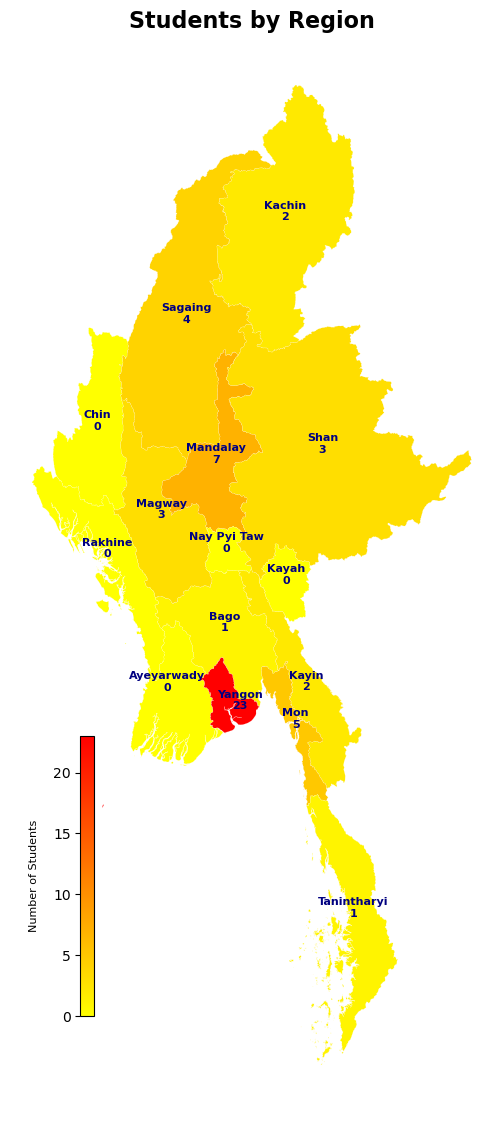

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

map_plot = myanmar_map_student.plot(
    column='Student_Count', 
    ax=ax, 
    legend=True, 
    cmap='autumn_r', 
    edgecolor='white', 
    linewidth=0.1,
    )

cbar = map_plot.get_figure().axes[-1]
cbar.set_position([0.45, 0.18, 0.1, 0.2])
cbar.yaxis.set_label_position('left')
cbar.yaxis.tick_left()
cbar.set_ylabel('Number of Students', fontsize=8, labelpad=10)

for x, y, label, count in zip(
    myanmar_map_student.geometry.centroid.x,
    myanmar_map_student.geometry.centroid.y,
    myanmar_map_student['ST'], 
    myanmar_map_student['Student_Count']
):
    if label == 'Yangon':
        x, y = x + 30000, y - 20000 
    elif label == 'Ayeyarwady':
        x, y = x - 20000, y + 30000

    ax.annotate(
        f"{label}\n{int(count)}", 
        xy=(x, y), 
        fontsize=8, 
        ha='center', 
        color='navy', 
        weight='bold')

ax.set_title('Students by Region', fontsize=16, fontweight='bold')

plt.axis('off')
plt.show()

# Commitment Level Calculation based on Regions

In [10]:
commitment_level = all_batch.pivot_table(index='Location', columns='Commitment', aggfunc='size', fill_value=0)

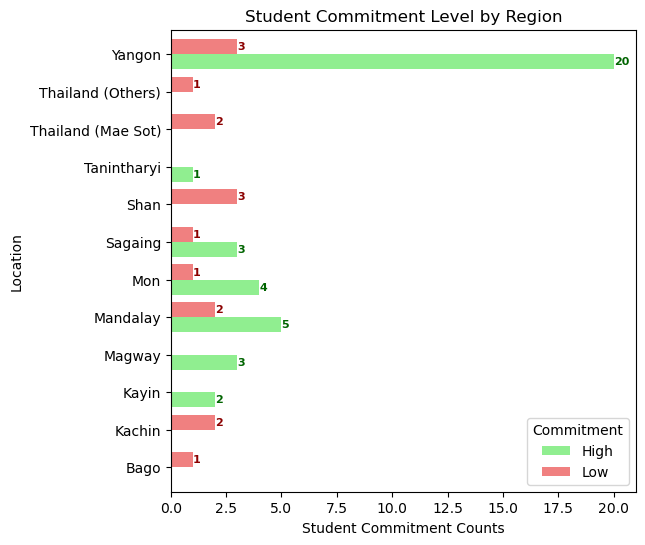

In [11]:
commitment_level.plot.barh(rot=0, color=['lightgreen', 'lightcoral'], width=0.8, figsize=(6,6))

for i, (location, row) in enumerate(commitment_level.iterrows()):
   
    high_count = row['High']
    if high_count > 0: 
        plt.text(high_count, i - 0.2, f'{high_count}', va='center', ha='left', fontsize=8, color='darkgreen', weight='bold')
    
    low_count = row['Low']
    if low_count > 0:  
        plt.text(low_count, i + 0.2, f'{low_count}', va='center', ha='left', fontsize=8, color='darkred', weight='bold')

plt.xlabel('Student Commitment Counts')
plt.title('Student Commitment Level by Region')
plt.show()

In [12]:
commitment_level['Commitment_Level'] = commitment_level.apply(lambda row: 'High' if row['High'] > row['Low'] else 'Low', axis=1)

In [13]:
commitment_level['Total'] = commitment_level['High'] + commitment_level['Low']
commitment_level['High_Percentage'] = (commitment_level['High'] / commitment_level['Total']) * 100
commitment_level['Low_Percentage'] = (commitment_level['Low'] / commitment_level['Total']) * 100

In [14]:
myanmar_map_commitment = myanmar_map.merge(commitment_level, how='left', left_on='ST', right_on='Location')

In [15]:
# #Ploting map commitment levels with Count
# color_mapping = {
#     'High' : 'lightgreen',
#     'Low' : 'lightcoral'
# }

# cmap = ListedColormap([color_mapping['High'], color_mapping['Low']])


# fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# myanmar_map_commitment.plot(
#     column='Commitment_Level',
#     ax=ax,
#     cmap=cmap, 
#     legend=True,
#     edgecolor='navy', 
#     linewidth=0.1,
#     missing_kwds={
#         "color": "lightgrey",
#         "edgecolor": "red",
#         "label": "No Student",
#     },
#     )

# for x, y, label, commitment in zip(
#     myanmar_map_commitment.geometry.centroid.x,
#     myanmar_map_commitment.geometry.centroid.y,
#     myanmar_map_commitment['ST'], 
#     myanmar_map_commitment['Commitment_Level']
# ):
#     if label == 'Yangon':
#         x, y = x + 30000, y - 20000 
#     elif label == 'Ayeyarwady':
#         x, y = x - 20000, y + 30000

#     if commitment in ['High', 'Low']:
#         count = myanmar_map_commitment.loc[myanmar_map_commitment['ST'] == label, commitment].values[0]
#     else:
#         count = 0

#     ax.annotate(
#         f"{label}\n{int(count)}", 
#         xy=(x, y), 
#         fontsize=8, 
#         ha='center', 
#         color='navy', 
#         weight='bold')


# ax.set_title('Students Commitment Level by Region', fontsize=16, fontweight='bold')

# plt.axis('off')
# plt.show()

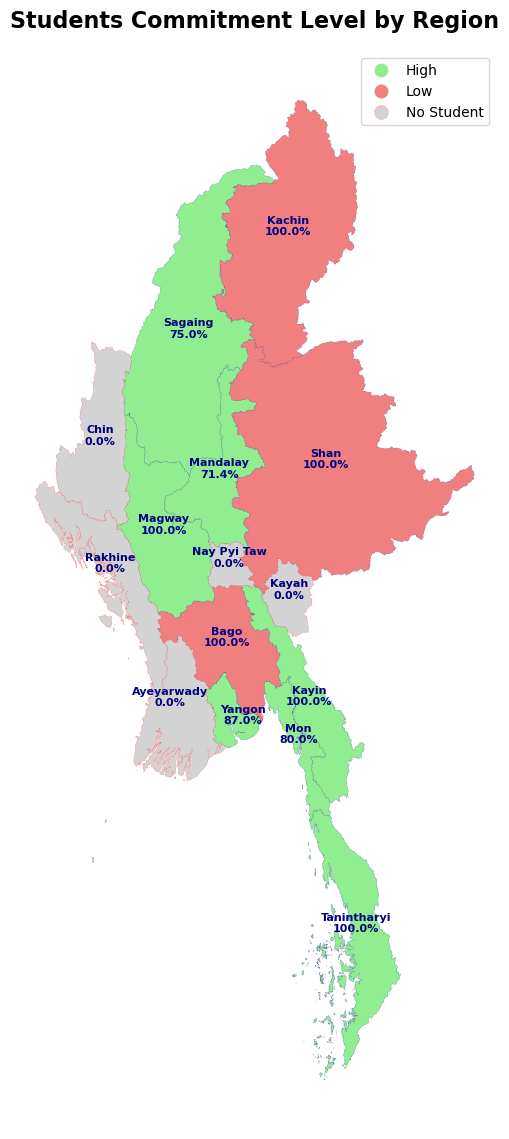

In [16]:
#Ploting map commitment levels with Percentage
color_mapping = {
    'High' : 'lightgreen',
    'Low' : 'lightcoral'
}

cmap = ListedColormap([color_mapping['High'], color_mapping['Low']])

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

myanmar_map_commitment.plot(
    column='Commitment_Level',
    ax=ax,
    cmap=cmap, 
    legend=True,
    edgecolor='navy', 
    linewidth=0.1,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "No Student",
    },
    )

for x, y, label, commitment in zip(
    myanmar_map_commitment.geometry.centroid.x,
    myanmar_map_commitment.geometry.centroid.y,
    myanmar_map_commitment['ST'], 
    myanmar_map_commitment['Commitment_Level']
):
    if label == 'Yangon':
        x, y = x + 30000, y - 20000 
    elif label == 'Ayeyarwady':
        x, y = x - 20000, y + 30000

    if commitment == 'High':
        percentage = myanmar_map_commitment.loc[myanmar_map_commitment['ST'] == label, 'High_Percentage'].values[0]
    elif commitment == 'Low':
        percentage = myanmar_map_commitment.loc[myanmar_map_commitment['ST'] == label, 'Low_Percentage'].values[0]
    else:
        percentage = 0

    ax.annotate(
        f"{label}\n{percentage:.1f}%",  
        xy=(x, y), 
        fontsize=8, 
        ha='center', 
        color='navy', 
        weight='bold')


ax.set_title('Students Commitment Level by Region', fontsize=16, fontweight='bold')

plt.axis('off')
plt.show()

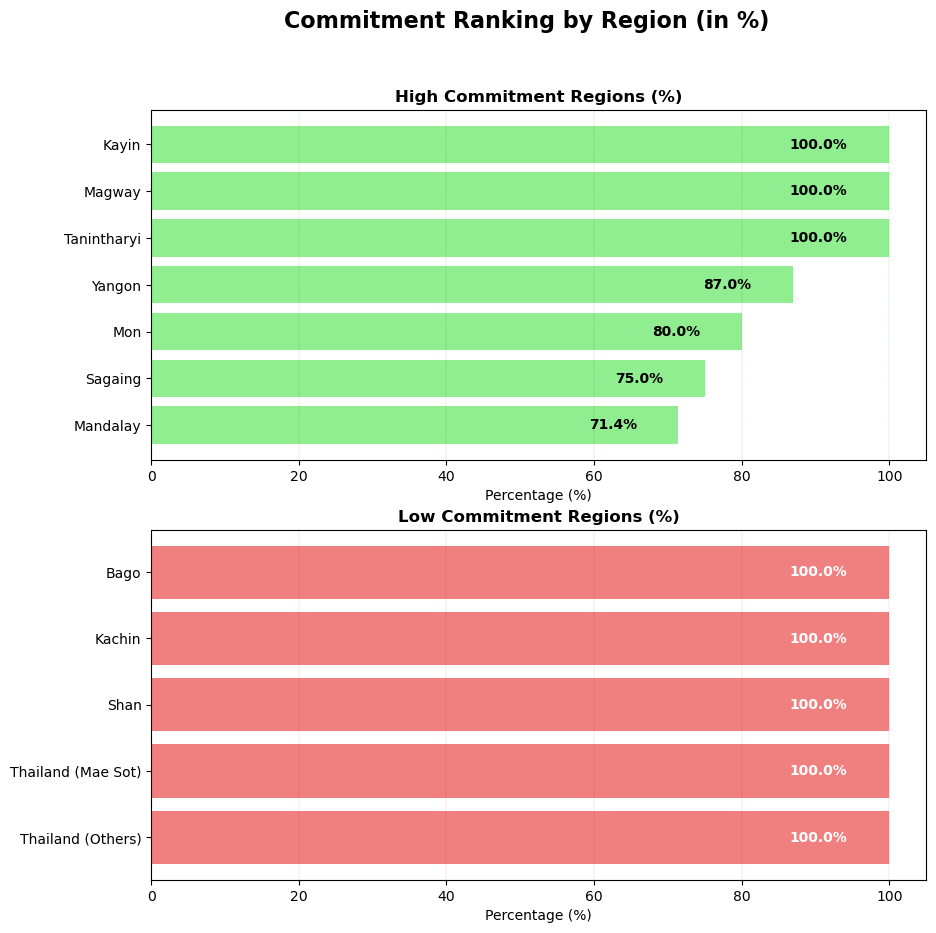

In [45]:
high_commitment_region = commitment_level.loc[commitment_level['Commitment_Level'] == 'High'].sort_values('High_Percentage', ascending=False)
high_commitment_region.drop(columns=['Low', 'Commitment_Level', 'Total', 'Low_Percentage'], inplace=True)

low_commitment_region = commitment_level.loc[commitment_level['Commitment_Level'] == 'Low'].sort_values('Low_Percentage', ascending=False)
low_commitment_region.drop(columns=['High', 'Commitment_Level', 'Total', 'High_Percentage'], inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

bars = ax[0].barh(high_commitment_region.index, high_commitment_region['High_Percentage'], color='lightgreen')
ax[0].set_title('High Commitment Regions (%)', fontweight='bold')
ax[0].invert_yaxis()
ax[0].grid(axis='x', color='g', linestyle=':', linewidth=0.2)
ax[0].set_xlabel('Percentage (%)')

for bar in bars:
    width = bar.get_width()
    ax[0].annotate(f'{width:.1f}%', 
                   xy=(width, bar.get_y() + bar.get_height() / 2),
                   xytext=(-30, 0),
                   textcoords="offset points",
                   ha='right',
                   va='center',
                   fontsize=10,
                   fontweight='bold',
                   color='black')

bars = ax[1].barh(low_commitment_region.index, low_commitment_region['Low_Percentage'], color='lightcoral')
ax[1].set_title('Low Commitment Regions (%)', fontweight='bold')
ax[1].invert_yaxis()
ax[1].grid(axis='x', color='r', linestyle=':', linewidth=0.2)
ax[1].set_xlabel('Percentage (%)')

for bar in bars:
    width = bar.get_width()
    ax[1].annotate(f'{width:.1f}%', 
                   xy=(width, bar.get_y() + bar.get_height() / 2),
                   xytext=(-30, 0),
                   textcoords="offset points",
                   ha='right',
                   va='center',
                   fontsize=10,
                   fontweight='bold',
                   color='white')

plt.suptitle('Commitment Ranking by Region (in %)', fontsize=16, fontweight='bold')
plt.show()

In [18]:
# #High and Low Commitment level by Region barh charts

# high_commitment_region = commitment_level.loc[commitment_level['Commitment_Level'] == 'High'].sort_values('High', ascending=False)
# high_commitment_region.drop(columns=['Low', 'Commitment_Level'], inplace=True)

# low_commitment_region = commitment_level.loc[commitment_level['Commitment_Level'] == 'Low'].sort_values('Low', ascending=False)
# low_commitment_region.drop(columns=['High', 'Commitment_Level'], inplace=True)

# fig, ax = plt.subplots(2, 1, figsize=(10,10))

# ax[0].barh(high_commitment_region.index, high_commitment_region['High'], color='lightgreen')
# ax[0].set_title('High Commitment Regions', fontweight='bold')
# ax[0].invert_yaxis()
# ax[0].grid(axis='x', color='g', linestyle=':', linewidth=0.2)
# ax[0].set_xlabel('Student Count')

# ax[1].barh(low_commitment_region.index, low_commitment_region['Low'], color='lightcoral')
# ax[1].set_title('Low Commitment Regions', fontweight='bold')
# ax[1].invert_yaxis()
# ax[1].grid(axis='x', color='r', linestyle=':', linewidth=0.2)
# ax[1].set_xlabel('Student Count')

# plt.suptitle('Commitment Ranking by Region', fontsize=16, fontweight='bold')
# plt.show()

# Commitment Level Calculation based on Data Points

In [19]:
comit_lvl_region = all_batch.pivot_table(index=['Location', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)
comit_lvl_age = all_batch.pivot_table(index=['Age', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)
comit_lvl_edu = all_batch.pivot_table(index=['Highest Education', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)
comit_lvl_socio = all_batch.pivot_table(index=['Socio-economic background', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)

In [20]:
high_comit_region = comit_lvl_region.xs('High', level='Commitment')
low_comit_region = comit_lvl_region.xs('Low', level='Commitment')

high_comit_age = comit_lvl_age.xs('High', level='Commitment')
low_comit_age = comit_lvl_age.xs('Low', level='Commitment')

high_comit_edu = comit_lvl_edu.xs('High', level='Commitment')
low_comit_edu = comit_lvl_edu.xs('Low', level='Commitment')

high_comit_socio = comit_lvl_socio.xs('High', level='Commitment')
low_comit_socio = comit_lvl_socio.xs('Low', level='Commitment')

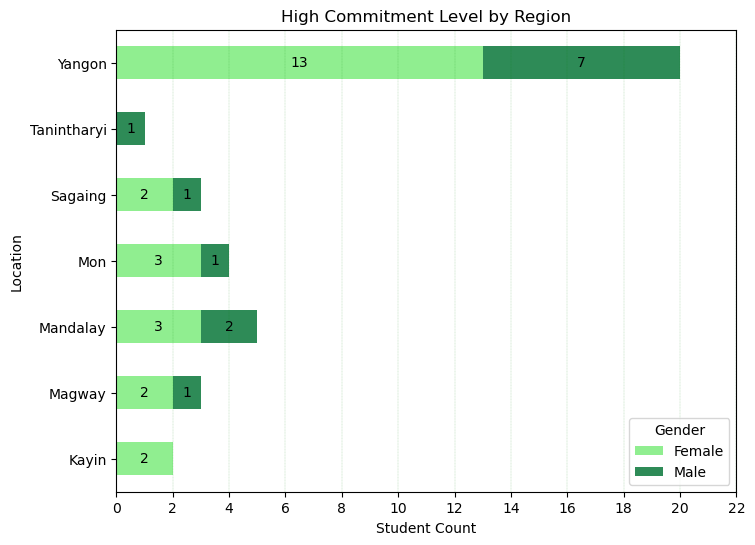

In [21]:
ax = high_comit_region.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(8,6),stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='black')
        
plt.title('High Commitment Level by Region')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.xticks(range(0, 24, 2))
plt.show()

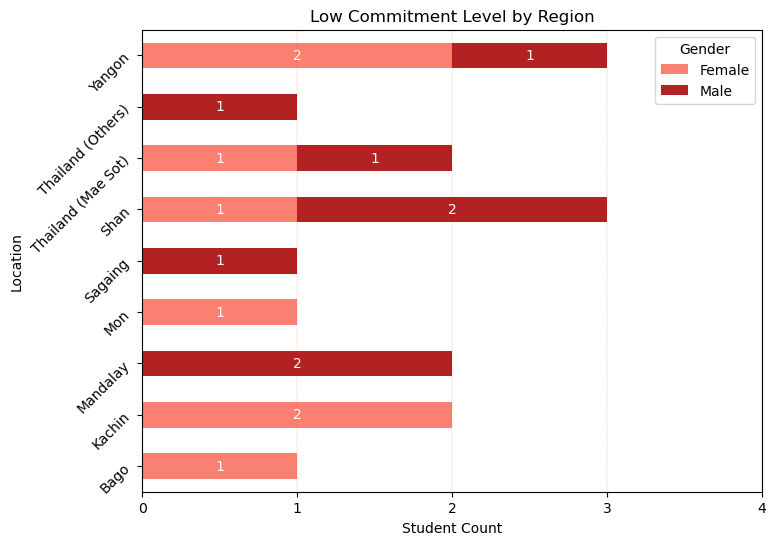

In [22]:
ax = low_comit_region.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(8,6), stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='w')

plt.title('Low Commitment Level by Region')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.yticks(rotation=45)
plt.xticks(range(0, 5, 1))
plt.show()

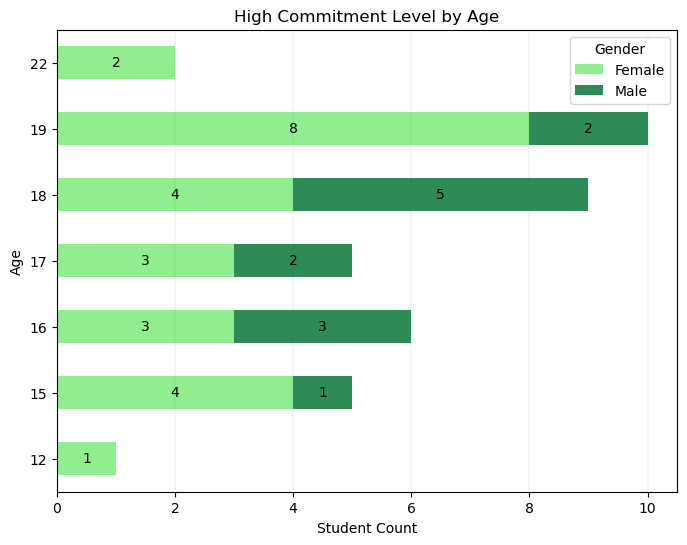

In [23]:
ax = high_comit_age.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(8,6), stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='black')
        
plt.title('High Commitment Level by Age')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.show()

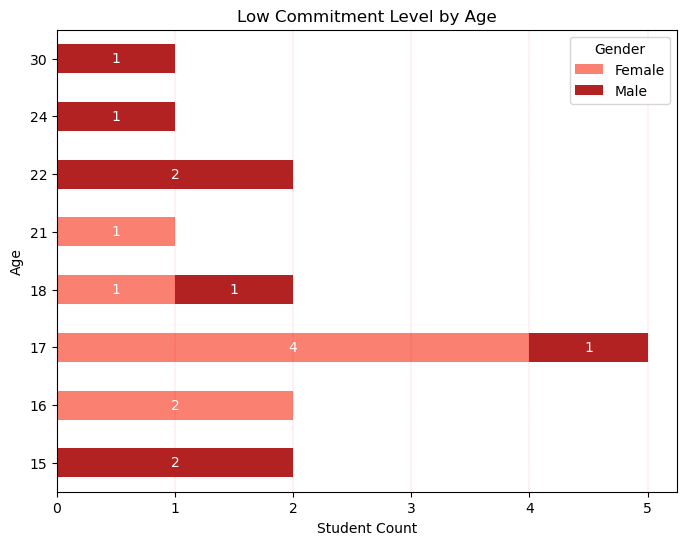

In [24]:
ax = low_comit_age.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(8,6), stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='w')
        
plt.title('Low Commitment Level by Age')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.xticks(range(0, 6, 1))
plt.show()

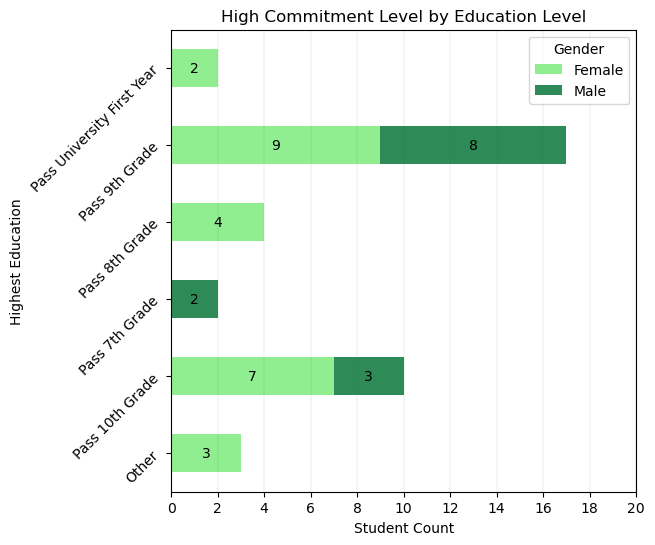

In [25]:
ax = high_comit_edu.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(6,6), stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='black')
        
plt.title('High Commitment Level by Education Level')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.yticks(rotation=45)
plt.xticks(range(0, 22, 2))
plt.show()

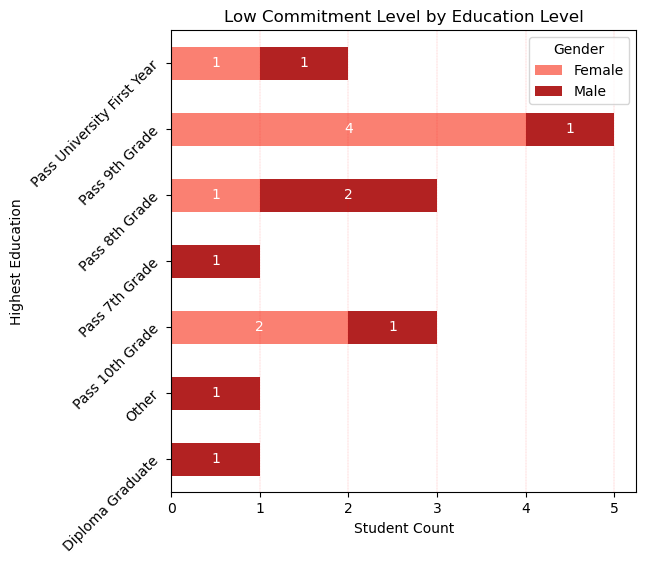

In [26]:
ax = low_comit_edu.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(6,6), stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='white')
        
plt.title('Low Commitment Level by Education Level')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.yticks(rotation=45)
plt.xticks(range(0, 6, 1))
plt.show()

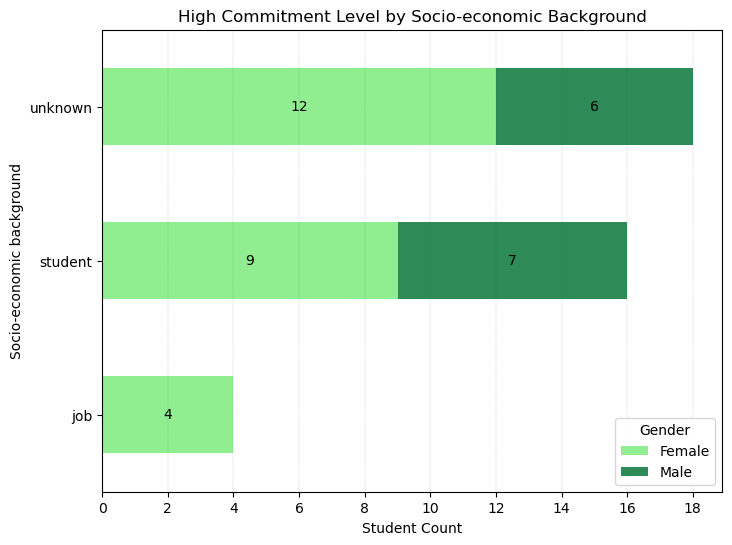

In [27]:
ax = high_comit_socio.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(8,6), stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='black')
        
plt.title('High Commitment Level by Socio-economic Background')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.xticks(range(0, 20, 2))
plt.show()

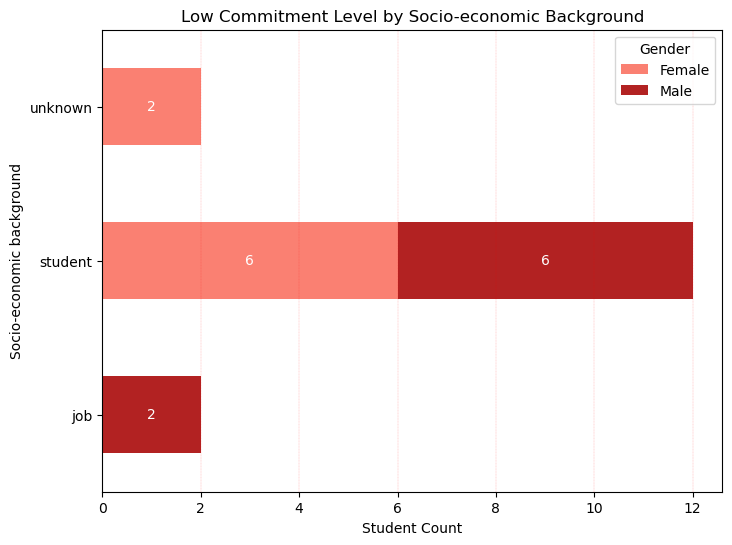

In [28]:
ax = low_comit_socio.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(8,6), stacked=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                int(width), va='center', ha='center', color='white')
        
plt.title('Low Commitment Level by Socio-economic Background')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.show()

# Sankey Diagram for Applicants and Acceptance %

In [29]:
first_applicants = pd.read_csv('../raw_data/1stBatch_Applicants.csv')
second_applicants = pd.read_csv('../raw_data/2ndBatch_Applicants.csv', encoding='ISO-8859-1')

total_applicants = first_applicants.shape[0] + second_applicants.shape[0]

total_students = len(all_batch)

total_rejected = total_applicants - total_students

commitment_counts = all_batch['Commitment'].value_counts()

# labels = ['Total Applicants', 'Total Students', 'Rejected', 'High Commitment', 'Low Commitment']
values = [total_students, total_rejected,  commitment_counts.get('High', 0), commitment_counts.get('Low', 0)]

percentages = [value / total_applicants * 100 for value in values]

labels = [
    f'Total Applicants\n{total_applicants} ({total_applicants / total_applicants * 100:.1f}%)',
    f'Total Students\n{total_students} ({percentages[0]:.1f}%)',
    f'Rejected\n{total_rejected} ({percentages[1]:.1f}%)',
    f'High Commitment\n{commitment_counts.get("High", 0)} ({commitment_counts.get("High", 0) / total_students * 100:.1f}%)',
    f'Low Commitment\n{commitment_counts.get("Low", 0)} ({commitment_counts.get("Low", 0) / total_students * 100:.1f}%)'
]

source = [0, 0, 1, 1]  
target = [1, 2, 3, 4]  

link_colors = ['LightSkyBlue', 'lightgray', 'lightgreen', 'lightcoral']
node_colors = ['DodgerBlue', 'DodgerBlue', 'gray', 'seagreen', 'firebrick']

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,
        align='left',
        x=[0, 0.5, 0.5, 1, 1], 
        y=[0.5, 0.3, 0.8, 0.3, 0.1] 
    ),
    link=dict(
        source=source,  
        target=target,  
        value=values,    
        color=link_colors
    )
)])

fig.update_layout(title_text="Student Commitment Levels", font_size=12)

fig.show()



In [30]:
# # Print out high res Sankey diagram
# fig.update_layout(
#     title_text="Student Commitment Levels",
#     font_size=36,
#     width=2400,
#     height=2000,
#     margin=dict(l=50, r=50, t=80, b=100)  
# )

# fig.write_image("high_res_sankey.png", width=2400, height=1000, scale=2)